자연어 처리(NLP) 
==============
[Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data)
--------------------------------------------------------

[강의 출처](https://programmers.co.kr/learn/courses/21/lessons/1693)

### 자연 언어 처리란
* 인간이 발화하는 언어 현상을 기계적으로 분석해서 컴퓨터가 이해할 수 있는 형태로 만드는 자연언어를 의미한다
-----------------
### 평가 - ROC Curve (Receiver - Operating Charateristic curve)
* 정의: TRP(True Positive Rate)와 FPR(False PR)을 각각 X,Y축으로 놓은 그래프
* 종류
 1. 민감도 TPR
     * 1인 케이스에 대해 1로 예측한 비율<BR>
         EX) 암 환자를 진찰해서 암이라고 진단함
 2. 특이도 FPR
     * 0인 케이스에 대해 1로 잘못 예측한 비율<BR>
         EX) 암 환자가 아닌데 암이라고 진단함
* 특징
 1. X,Y가 둘 다 \[0,1\]범위이고 (0,0)~(1,1)인 곡선이다
 2. ROC 커브의 면적이 1에 가까울수록 성능이 좋다.
----------------------
### BOW(Bag Of Words)
* 특징
    1. 가장 간단하고 효과적인 방법
    2. 장, 문단, 문장, 서식과 같은 입력 텍스트 구조를 제외하고 각 단어가 얼마나 많이 나타나는지만 헤아린다. (문장, 문단 단어를 가방에 넣고 쏟아낸다 -> 순서가 영향을 끼치지 않음)
    3. 단어의 순서는 완전히 무시된다.
    4. 이를 보완하기 위해 n-gram을 사용한다. (help -(2-gram)-> he,el,lp)
    

Part 1
=======
IMDB 영화리뷰를 로딩하고 정제하여 BOW모델을 적용하여 예측도를 검사한다.
------------------------------------------------------------------

---------------------------------------
## 1. 데이터 불러오기 & 특징 찾기

In [1]:
import pandas as pd
import nltk #pip install nltk

In [2]:
# header=0: 파일의 첫번째 줄에 열 이름 존재
# delimiter = \t: 필드가 탭으로 구분된다
# quoting = 3: 큰따옴표를 무시한다.

# 레이블인 sentiment가 있는 학습 데이터 (정답표)
train = pd.read_csv('./data/labeledTrainData.tsv',header=0,delimiter='\t',quoting=3)
# 레이블이 없는 테스트 데이터
test = pd.read_csv('./data/testData.tsv',header=0,delimiter='\t',quoting=3)

# train data의 행과 열의 개수를 나타낸다
train.shape

(25000, 3)

In [3]:
# train data의 끝에서 3번째 데이터 출력
train.tail(3)

,id,sentiment,review
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."
24999,"""8478_8""",1,"""I saw this movie as a child and it broke my h..."


In [4]:
# tail의 default는 5
test.tail()

,id,review
24995,"""2155_10""","""Sony Pictures Classics, I'm looking at you! S..."
24996,"""59_10""","""I always felt that Ms. Merkerson had never go..."
24997,"""2531_1""","""I was so disappointed in this movie. I am ver..."
24998,"""7772_8""","""From the opening sequence, filled with black ..."
24999,"""11465_10""","""This is a great horror film for people who do..."


In [5]:
# 각 열의 이름값 출력
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [6]:
# 데이터의 정보 출력 1
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [7]:
# 데이터의 정보 출력 2
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [8]:
# sentiment column의 특정 값들의 개수
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [9]:
# train의 review column의 첫번쨰 행값의 0~700 index까지의 정보 출력
train['review'][0][:700]
#html tag를 정제해줄 필요성이 보인다.

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

------------------------
## 2. 텍스트 데이터 전처리 하기

##### 전처리 과정
    1. HTML 태그 제거
    2. 알파벳 이외의 문자를 공백으로 치환
    3. STOPWORD 제거
    4. STEMMING & LEMMATIZING
--------------------------------------
##### 텍스트 전처리
1. 정규화(Normalization): 용도에 맞게 데이터를 정제하는 일<br>
    ex) 입니닼ㅋㅋ -> 입니다ㅋㅋ, 샤릉해->사랑해
    
    
2. 토큰화(Tokenization): 용도에 맞게 토큰을 분류하는 작업<br>
    ex) 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하는Verb, 예시Noun, 입Adjective, 니다Eomi ㅋㅋKoreanParticle
    
    
3. 어근화(Stemming): 어간을 추출하는 것. 즉, 규칙에 따라 단어의 어미를 자르는 것<br>
    ex) 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하다Verb, 예시Noun, 이다Adjective, ㅋㅋKoreanParticle<br>
    -> 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있게 한다.
    
    
4. 어구 추출(Pharse extraction)<br>
    ex) 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어, 처리, 예시, 처리하는 예시
    
    
5. 음소 표기(Lemmatization): 기본 사전형 단어. 뿌리단어 찾기<br>
    ex) is,are,been -> be
    -> 앞뒤 문맥을 보고 단어의 의미를 식별하는 것 (동음이의어)


6. 불용어(Stop word): 큰 의미가 없는 단어 토큰을 제거하는 작업<br>
    ex) the,an,a ...
 

* nltk나 tiwitter 한국어 처리기 등의 다양한 오픈 소스가 존재한다.


In [10]:
from bs4 import BeautifulSoup# html 태그 제거
import re #정규 표현식
#stopword
import nltk
from nltk.corpus import stopwords
#stemming
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
#lemmatization
from nltk.stem import WordNetLemmatizer

In [11]:
# 1. html tag 제거
example1 = BeautifulSoup(train['review'][0],"html5lib")
print(train['review'][0][:700])
example1.get_text()[:700]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [12]:
# 정규 표현식을 사용하여 특수문자 제거
# 2. 소문자나 대문자가 아니면 공백으로 대체한다.
letters_only = re.sub('[^a-zA-Z]',' ',example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [13]:
#모두 소문자로 변환한다.
lower_case = letters_only.lower()
#Tokenization
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

In [14]:
# 3. Stopword 제거
nltk.download('stopwords') #따로 설치해야 한다!
stopwords.words('english')[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cktnw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [15]:
# stopwords를 토큰에거 제거
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [16]:
# 4-1.Stemming

#Porter stemmer
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [17]:
#Lnacaster stemmer
lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print("The stemmed form of running is: {}".format(lancaster_stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(lancaster_stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(lancaster_stemmer.stem("run")))


maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [18]:
# 처리하기 전 단어
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [19]:
stemmer = SnowballStemmer('english')
words = [stemmer.stem(w) for w in words]
words[:10]

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

In [20]:
# 4-2. Lemmatization
nltk.download('wordnet')#download
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

words = [wordnet_lemmatizer.lemmatize(w) for w in words]

words[:10]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cktnw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
fly
fly


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

-----------------------------------------------
### 앞의 과정을 모두 모아 하나의 함수로 정의하였다.

In [21]:
def review_to_words( raw_review ):
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    return( ' '.join(stemming_words) )

In [22]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [23]:
#이제 이 과정을 전테 텍스트에 적용 -> 수가 많아서 스레드로 처리한다
from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func,**kwargs)
def apply_by_multiprocessing(df,func,**kwargs):
    workers = kwargs.pop('workers') #받아온 파라미터에서 workers를 꺼내온다
    pool = Pool(processes=workers) # workers만큼의 수로 프로세스 풀을 셜정
    result = pool.map(_apply_df,[(d,func,kwargs) for d in np.array_split(df,workers)])
    pool.close()
    return pd.concat(list(result)) #작업 결과를 합쳐서 반환

In [24]:
#스레드 이용
#%time clean_test_reviews = apply_by_multiprocessing(test['review'],review_to_words,workers=4)
#%time clean_train_reviews = apply_by_multiprocessing(train['review'],review_to_words,workers=4)

In [25]:
#그냥 for문으로 돌림
num_reviews = train['review'].size
clean_train_reviews = []
for i in range(0, num_reviews):
    if (i + 1)%5000 == 0:
         print('Review {} of {} '.format(i+1, num_reviews))
    clean_train_reviews.append(review_to_words(train['review'][i]))


Review 5000 of 25000 
Review 10000 of 25000 
Review 15000 of 25000 
Review 20000 of 25000 
Review 25000 of 25000 


In [26]:
num_reviews = test['review'].size
clean_test_reviews = []
for i in range(0, num_reviews):
    if (i + 1)%5000 == 0:
         print('Review {} of {} '.format(i+1, num_reviews))
    clean_test_reviews.append(review_to_words(test['review'][i]))

Review 5000 of 25000 
Review 10000 of 25000 
Review 15000 of 25000 
Review 20000 of 25000 
Review 25000 of 25000 


-----------------------------------------------------
## 3. CountVectorizer로 텍스트 벡터화


### 워드 클라우드
* 단어의 빈도수 데이터를 가지고 있을때 이용할 수 있는 시각화 방법
* 단순히 빈도수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는게 더 의미있기에 큰 정보를 얻기는 어렵다.
### scikit learn의 CountVectorizer 사용

In [27]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import seaborn as sns


In [28]:
# 주피터 노트북에서 그래프를 그릴 수 있게 한다
%matplotlib inline

def displayWordCloud(data=None, backgroundcolor='white',width=800,height=600):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color=backgroundcolor,
                          width=width,height=height).generate(data)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

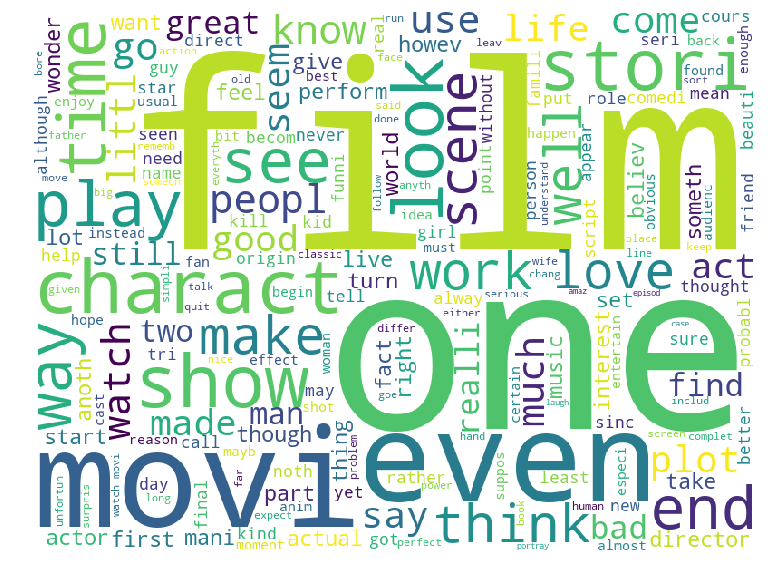

Wall time: 20.5 s


In [29]:
# 학습 데이터의 모든 단어에 대한 워드 클라우드 생성
%time displayWordCloud(' '.join(clean_train_reviews))

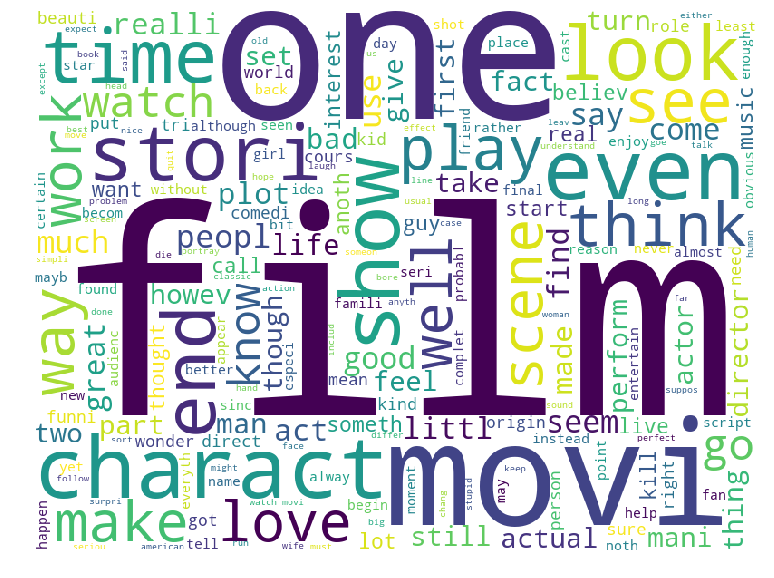

Wall time: 20.6 s


In [30]:
# 테스트 데이터에 대한 워드 클라우드
%time displayWordCloud(' '.join(clean_test_reviews))

In [65]:
#train에 단어의 수와 중복을 제거한 단어의 수를 추가한다

#컬럼을 초기화하구 그 다음에 값을 바꾸자
train['num_words'] = 0
train['num_uniq_words'] = 0
test['num_words'] = 0
test['num_uniq_words'] = 0

for i in range(0,num_reviews):
    if (i + 1)%5000 == 0:
         print('Review {} of {} '.format(i+1, num_reviews))
    train.at[i,'num_words']= len(str(clean_train_reviews[i]).split()) 
    train.at[i,'num_uniq_words']= len(set(str(clean_train_reviews[i]).split()))
    test.at[i,'num_words']= len(str(clean_test_reviews[i]).split()) 
    test.at[i,'num_uniq_words']= len(set(str(clean_test_reviews[i]).split()))
'''  
#apply는 잘 안돌아가네
train['num_words'] = clean_train_reviews.apply(lambda x: len(str(x).split()))
# set은 중복이 불가능 하기 때문이다
train['num_uniq_words'] = clean_train_reviews.apply(lambda x: len(set(str(x).split())))
'''

Review 5000 of 25000 
Review 10000 of 25000 
Review 15000 of 25000 
Review 20000 of 25000 
Review 25000 of 25000 


"  \n#apply는 잘 안돌아가네\ntrain['num_words'] = clean_train_reviews.apply(lambda x: len(str(x).split()))\n# set은 중복이 불가능 하기 때문이다\ntrain['num_uniq_words'] = clean_train_reviews.apply(lambda x: len(set(str(x).split())))\n"

In [66]:
train.head()

,id,sentiment,review,num_words,num_uniq_words
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",219,156
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",84,63
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",240,201
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",189,158
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",210,188


In [67]:
#첫 번째 리뷰
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]


219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

### 리뷰 분석

리뷰 별 단어 평균값:  119.52356
리뷰 별 단어 중간값:  89.0
리뷰 별 고유 단어 평균값:  94.05756
리뷰 별 고유 단어 중간값:  74.0


C:\Users\cktnw\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\cktnw\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'리뷰 별 단어 수 분포')

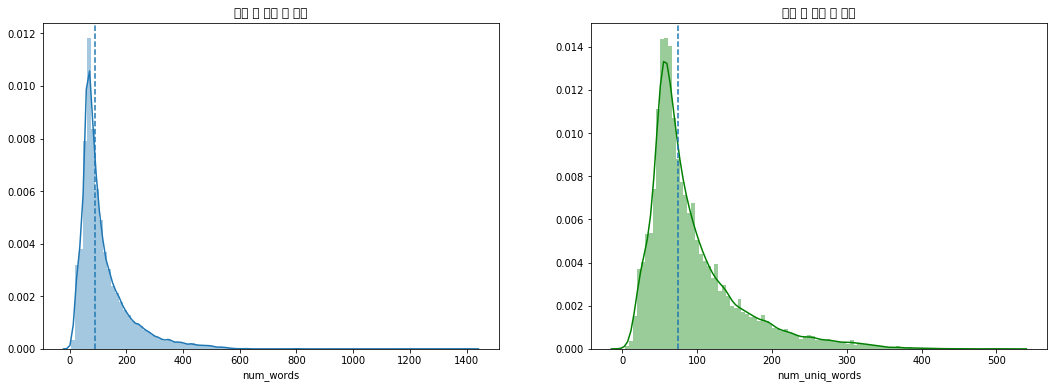

In [68]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18,6)
print('리뷰 별 단어 평균값: ',train['num_words'].mean())
print('리뷰 별 단어 중간값: ',train['num_words'].median())
sns.distplot(train['num_words'],bins=100,ax=axes[0])
axes[0].axvline(train['num_words'].median(),linestyle='dashed')
axes[0].set_title('리뷰 별 단어 수 분포')

print('리뷰 별 고유 단어 평균값: ',train['num_uniq_words'].mean())
print('리뷰 별 고유 단어 중간값: ',train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'],bins=100,color='g',ax=axes[1])
axes[1].axvline(train['num_uniq_words'].median(),linestyle='dashed')
axes[1].set_title('리뷰 별 단어 수 분포')

In [70]:
#countVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word',
                             tokenizer=None,
                             preprocessor=None,
                             stop_words=None,
                             min_df=2,
                            ngram_range=(1,3),
                            max_features=20000)
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [73]:
#pipeline은 속도 개선 용
pipeline = Pipeline([
    ('vect',vectorizer),
])

In [74]:
%time train_data_features = pipeline.fit_transform(clean_train_reviews)
train_data_features

Wall time: 30.3 s


<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762268 stored elements in Compressed Sparse Row format>

In [80]:
train_data_features.shape

(25000, 20000)

In [77]:
vocab = vectorizer.get_feature_names()
vocab[:10]

['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [82]:
dist = np.sum(train_data_features,axis=0)
for tag, count in zip(vocab,dist):
    print(count,tag)
pd.DataFrame(dist,columns=vocab)

[[26 48 22 ... 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [84]:
pd.DataFrame(train_data_features[:100].toarray(),columns=vocab).head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


----------------------------------
## 4. Random Forest
* randomness(임의성)에 의해 서로 조금씩 다른 특성으 갖는 트리들로 구성된다.
* 이 특징은 각 트리의 prediction들이 decorrelation되게 하며, 결과적으로 일반화 성능을 향상시킨다.
* 노이즈가 포함된 데이터에 대해서 강하다

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

C:\Users\cktnw\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [86]:
forest = RandomForestClassifier(n_estimators=100,n_jobs=-1)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [87]:
%time forest=forest.fit(train_data_features,train['sentiment'])

Wall time: 15.5 s


In [90]:
%time np.mean(cross_val_score(forest,train_data_features,train['sentiment'],cv=10,scoring='roc_auc'))

Wall time: 2min 3s


0.927528736

In [91]:
#정제한 첫번째 데이터
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [92]:
# 테스트 데이터를 벡터화 한다
%time test_data_features = pipeline.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

Wall time: 7.35 s


In [93]:
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [94]:
test_data_features[5][:100] #벡터화 된 단어로 숫자가 문서에서 등장한 횟수이다.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [95]:
#테스트 데이터로 예측해본다
result = forest.predict(test_data_features)
result[:10]

array([1, 0, 1, 0, 1, 1, 0, 0, 0, 1], dtype=int64)

In [97]:
output = pd.DataFrame(data={'id':test['id'],'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",0
4,"""12128_7""",1


In [98]:
output.to_csv('data/tutorial1.csv',index=False,quoting=3)

In [99]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0]-output_sentiment[1])
output_sentiment

80


0    12540
1    12460
Name: sentiment, dtype: int64

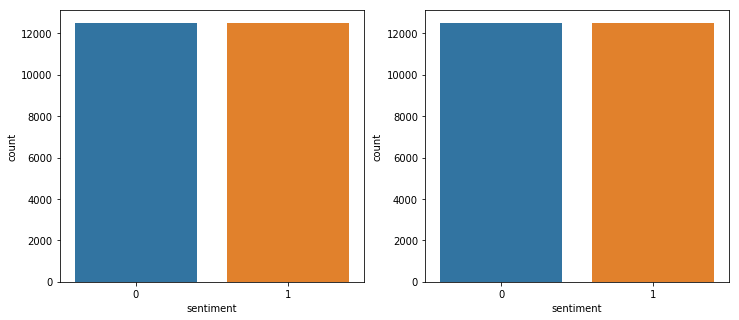

In [102]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'],ax=axes[0])
sns.countplot(train['sentiment'],ax=axes[1])